### Load and transform textual script data

In [1]:
import pandas as pd

# Get scripts data
script_csv_path = "./processed_data/combined_script_data.csv"
script_data = pd.read_csv(script_csv_path)
script_data = script_data.drop(columns=["release_year"])
# display(script_data)

# Get Oscar labels
oscar_labels_path = "./processed_data/oscar_data.csv"
oscar_label = pd.read_csv(oscar_labels_path).rename(columns={"entity": "title", "category": "nominated", "winner": "won"})
oscar_label = oscar_label.drop(columns=["year"])
oscar_label["nominated"] = True
# display(oscar_label)

# Merge script and Oscar data
script_oscar_df = pd.merge(script_data, oscar_label, how="outer", on="title")
script_oscar_df = script_oscar_df.dropna(subset=['script'])
script_oscar_df = script_oscar_df.fillna(False)
# display(script_oscar_df)

script_oscar_df['nominated'].astype('bool')
script_oscar_df['won'].astype('bool')
# print(script_oscar_df.dtypes)
# display(script_oscar_df)

script_oscar_df = script_oscar_df[script_oscar_df['nominated'] == script_oscar_df['won']].drop_duplicates()
script_oscar_df = script_oscar_df.drop(columns=['nominated'])
script_oscar_df['won'] = script_oscar_df['won'].astype(int)
display(script_oscar_df)

script_oscar_df.reset_index()
print('Done')

,title,script,won
1,When Worlds Collide,needl heaven haystack star heaven human earth ...,1
5,Reds,rememb im begin forget peopl use know rememb l...,1
12,Undefeated,let start right guard shot longer school start...,1
15,Seven Brides for Seven Brothers,deliv perfectionand dont brag d pound beaver w...,1
25,Henry V,oh muse ascend brightest heaven invent kingdom...,1
...,...,...,...
7441,The Roommate,hi hi sara matthew sara matthew room welcom th...,0
7442,Night of the Comet,record time swung univers ellipt orbit larg ex...,0
7443,Paddington,darkest peru vast unexplor wilder shroud myste...,0
7444,Jumanji: Welcome to the Jungle,ocean wave crash seagul squawk drum beat rhyth...,0


Done


In [2]:
features,labels = script_oscar_df['script'],script_oscar_df['won']
print('done')

done


### Create tfidf

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

def build_tfidf(xtrain):
    vectorizer = TfidfVectorizer(max_features=10000, min_df=0.05, max_df=0.5)
    # Fit the vectorizer here
    vectorizer.fit(xtrain)
    return vectorizer

Vectorizing data with tfidf...
done


### Exploratory Data Analysis

In [49]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

oscar_winners = script_oscar_df[script_oscar_df['won'] == 1]

# Cluster topics of winning movies
print('Using count vectorizer...')
count_vectorizer = CountVectorizer(max_features=100000, min_df=30, max_df=0.5)
cv_vectors = count_vectorizer.fit_transform(oscar_winners['script'])
print('Training lda...')
lda = LatentDirichletAllocation(n_components=25, random_state=0)
lda.fit(cv_vectors)
for i, topic in enumerate(lda.components_, start=1):
    # Your solution
    top_indices = sorted(range(len(topic)), key=lambda i: topic[i], reverse=True)[:5]
    top_words = ' '.join([count_vectorizer.get_feature_names()[ind] for ind in top_indices])
    print('Top in '+str(i)+':', top_words)

Using count vectorizer...
Training lda...
Top in 1: king lord majesti thou queen
Top in 2: lm lts lll lt lf
Top in 3: georg dad song record richard
Top in 4: ship captain aye command boat
Top in 5: christma senat church phil judg
Top in 6: frank bud don ann van
Top in 7: joe charli ben million virginia
Top in 8: uh american presid govern unit
Top in 9: control earth flight roger engin
Top in 10: captain general sergeant colonel armi
Top in 11: sam captain bull ring tree
Top in 12: mose gold lord papa slave
Top in 13: fuck shit wanna ass bitch
Top in 14: dr rose david patient hospit
Top in 15: ok bank million toni mark
Top in 16: em ya wanna goin doin
Top in 17: johnni ray rabbit fox willi
Top in 18: jane darl madam letter parent
Top in 19: mike michael mom danni andi
Top in 20: jack york boss john san
Top in 21: eddi wanna darl song phone
Top in 22: hors pa darl maam ma
Top in 23: howard gun shit roger tv
Top in 24: monsieur madam mari pari franc
Top in 25: uh ha um hmm whoa


In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

xtrain, xtest, ytrain, ytest = train_test_split(features, labels, random_state=0, test_size=0.2, stratify=labels)
print('Vectorizing data with tfidf...')
vectorizer = build_tfidf(xtrain)
tf_xtrain = vectorizer.transform(xtrain)
tf_xtest  = vectorizer.transform(xtest)
print('done')

# Do Confusion Matrix exploration on simple model
lr_clf = LogisticRegression(solver='saga', max_iter=1000).fit(tf_xtrain, ytrain)
pred = lr_clf.predict(tf_xtest)
tn, fp, fn, tp = confusion_matrix(ytest, pred).ravel()
print('Confusion matrix on simple logistic regression model:')
print('TN: {} TP: {} FP: {} FN: {}'.format(tn, tp, fp, fn))
pd.crosstab(ytest, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Confusion matrix on simple logistic regression model:
TN: 511 TP: 25 FP: 6 FN: 98


Predicted,0,1,All
True,,,
0,511,6,517
1,98,25,123
All,609,31,640


### Visualize data

In [64]:
import numpy as np

counts = CountVectorizer(max_features=10000, min_df=30, max_df=0.5).fit_transform(oscar_winners['script']).toarray().ravel()
words  = np.array(count_vectorizer.get_feature_names()) 
# normalize                                                                                                                                             
weights = counts / float(counts.max())
pairs = zip(words, counts)
wc_frequencies = {word: weight for word,weight in pairs}

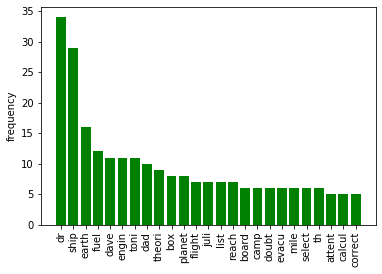

In [65]:
from collections import Counter

counter = Counter(wc_frequencies)
top_n = {k:v for k,v in counter.most_common(25)}
plt.bar(top_n.keys(), top_n.values(), 0.8, color='g')
plt.xticks(rotation='vertical')
plt.ylabel('frequency')
plt.show()

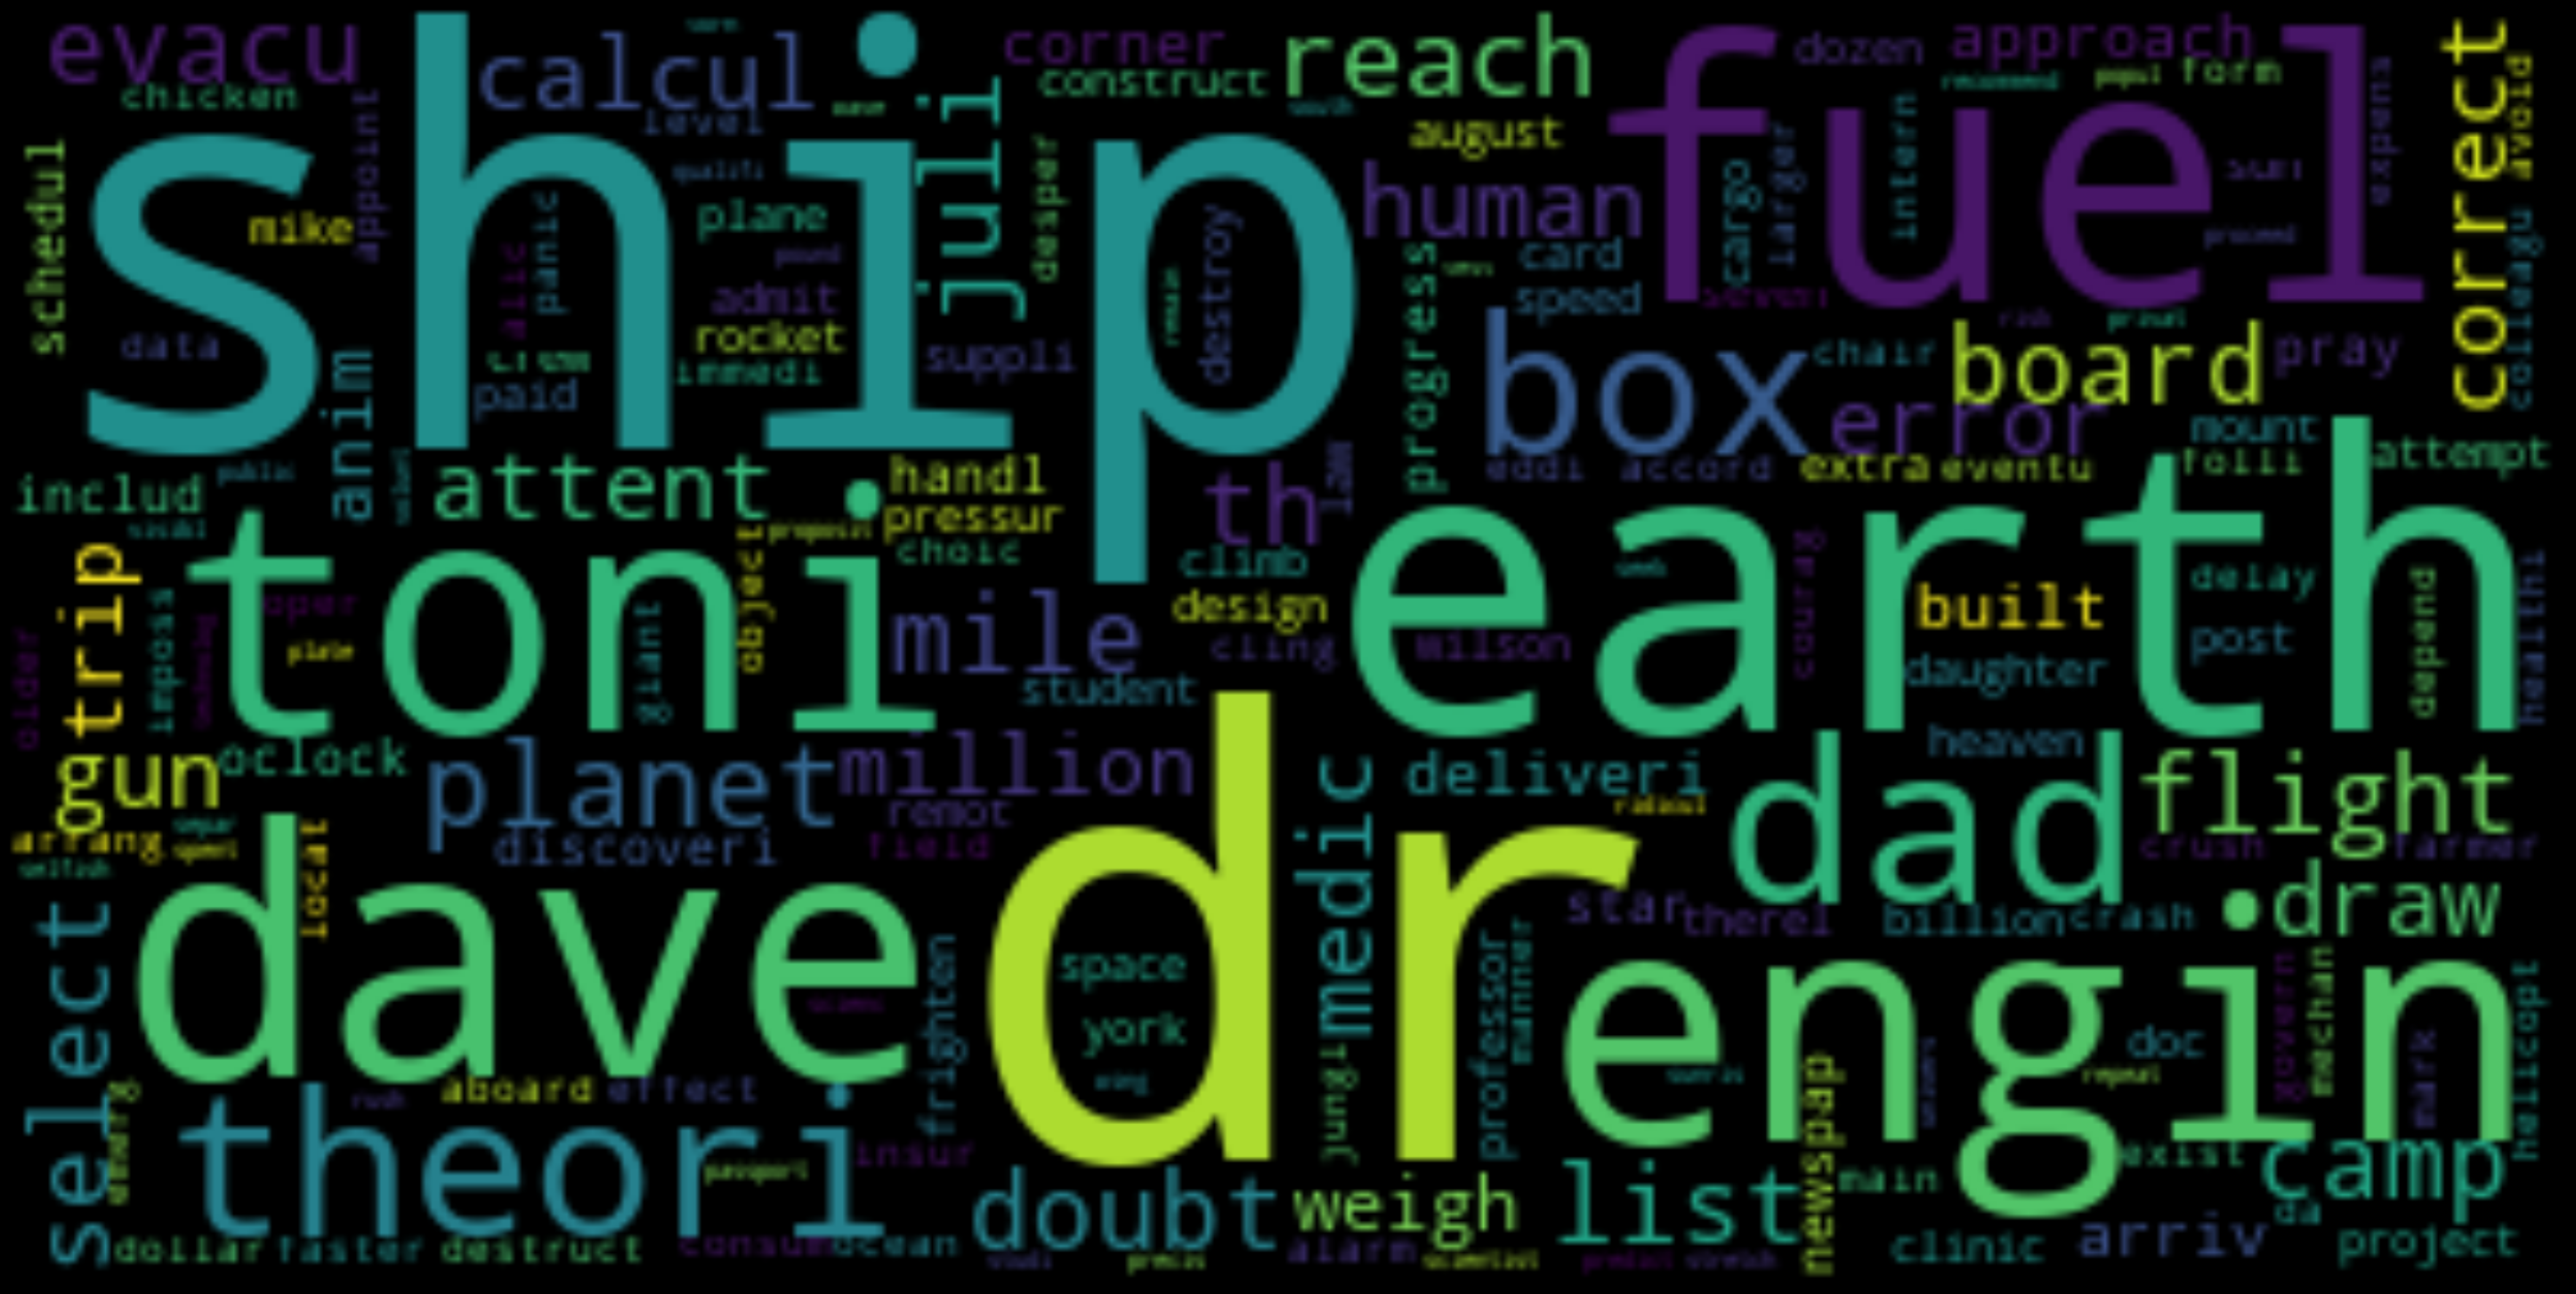

In [66]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# Word cloud of oscar winning scripts
cloud = WordCloud().generate_from_frequencies(wc_frequencies)
fig = plt.figure(figsize = (40, 30), facecolor = 'k', edgecolor = 'k')
plt.imshow(cloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### ML prediction

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def build_tfidf(xtrain):
    vectorizer = TfidfVectorizer(max_features=10000, min_df=0.1, max_df=0.3)
    # Fit the vectorizer here
    vectorizer.fit(xtrain)
    return vectorizer

def fit_eval(clf, xtest, xtrain, ytest, ytrain):
    clf.fit(xtrain, ytrain)
    ypred  = clf.predict(xtest)
    acc    = clf.score(xtest, ytest)
    prec   = precision_score(ypred, ytest, average='binary', pos_label=1)
    recall = recall_score(ypred, ytest, average='binary', pos_label=1)
    return acc,prec,recall

xtrain, xtest, ytrain, ytest = train_test_split(features, labels, random_state=0, test_size=0.2, stratify=labels)
print('Vectorizing data with tfidf...')
vectorizer = build_tfidf(xtrain)
tf_xtrain  = vectorizer.transform(xtrain)
tf_xtest   = vectorizer.transform(xtest)
acc1,prec1,recall1 = fit_eval(LogisticRegression(solver='saga', max_iter=1000), tf_xtrain, tf_xtest, ytrain, ytest)

print('Simple Logistic Regression Model:')
print('Accuracy: {}\nPrecision: {}\nRecall: {}'.format(acc1, prec1, recall1))

Vectorizing data with tfidf...
Simple Logistic Regression Model:
Accuracy: 0.8139898397811646
Precision: 0.04259634888438134
Recall: 0.84


In [110]:
# K fold prediction
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

skf = StratifiedKFold(n_splits=10)
split_num = 0
acc_dict,prec_dict,recall_dict = {'LR':[], 'NB':[], 'RF':[]},{'LR':[], 'NB':[], 'RF':[]},{'LR':[], 'NB':[], 'RF':[]}
for train_index, test_index in skf.split(features, labels):
    print('KFold split {}'.format(split_num))
    xtrain, xtest = features.iloc[train_index], features.iloc[test_index]
    ytrain, ytest = labels.iloc[train_index], labels.iloc[test_index]
    vectorizer = build_tfidf(xtrain)
    tf_xtrain  = vectorizer.transform(xtrain)
    tf_xtest   = vectorizer.transform(xtest)
    acc1,prec1,recall1 = fit_eval(LogisticRegression(solver='saga'), tf_xtrain, tf_xtest, ytrain, ytest)
    acc2,prec2,recall2 = fit_eval(BernoulliNB(), tf_xtrain, tf_xtest, ytrain, ytest)
    acc3,prec3,recall3 = fit_eval(RandomForestClassifier(), tf_xtrain, tf_xtest, ytrain, ytest)
    acc_dict['LR'].append(acc1), acc_dict['NB'].append(acc2), acc_dict['RF'].append(acc3)
    prec_dict['LR'].append(prec1), prec_dict['NB'].append(prec2), prec_dict['RF'].append(prec3)
    recall_dict['LR'].append(recall1), recall_dict['NB'].append(recall2), recall_dict['RF'].append(recall3)
    split_num += 1

KFold split 0


C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


KFold split 1


C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


KFold split 2


C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


KFold split 3


C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


KFold split 4


C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


KFold split 5


C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


KFold split 6


C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


KFold split 7


C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


KFold split 8


C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


KFold split 9


C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


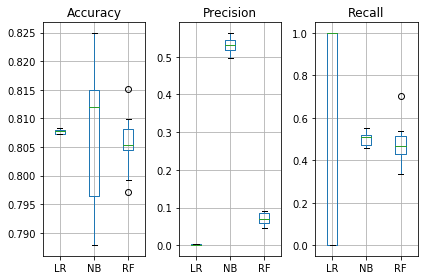

In [112]:
acc_df = pd.DataFrame(acc_dict)
prec_df = pd.DataFrame(prec_dict)
recall_df = pd.DataFrame(recall_dict)

plt.subplot(1, 3, 1)
acc_df.boxplot()
plt.title('Accuracy')

plt.subplot(1, 3, 2)
prec_df.boxplot()
plt.title('Precision')

plt.subplot(1, 3, 3)
recall_df.boxplot()
plt.title('Recall')

plt.tight_layout()
plt.show()